In [38]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from functions import *
from functions import plotting

(2115, 22, 1000)


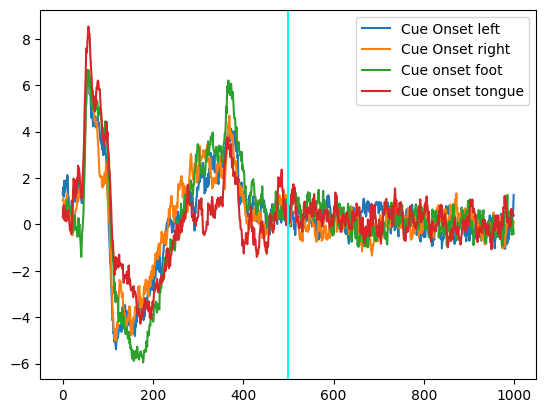

In [39]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("../ECEC147project-data/X_test.npy")
y_test = np.load("../ECEC147project-data//y_test.npy")
person_train_valid = np.load("../ECEC147project-data//person_train_valid.npy")
X_train_valid = np.load("../ECEC147project-data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("../ECEC147project-data/y_train_valid.npy")
person_test = np.load("../ECEC147project-data/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [40]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

In [41]:

# Preprocessing test dataset
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# First split then do preprocessing separately
# Creating the training and validation sets using the generated indices
(x_train_split, x_valid_split) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train_split, y_valid_split) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Preprocessing the dataset after split to prevent leakage (augmentation and smoothing)
x_train,y_train = train_data_prep(x_train_split,y_train_split,2,2,True)
x_valid,y_valid = train_data_prep(x_valid_split,y_valid_split,2,2,True)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (1865, 22, 800)
Shape of X after maxpooling: (1865, 22, 400)
Shape of X after averaging+noise and concatenating: (3730, 22, 400)
Shape of X after subsampling and concatenating: (7460, 22, 400)
Shape of Y: (7460,)
Shape of X after trimming: (250, 22, 800)
Shape of X after maxpooling: (250, 22, 400)
Shape of X after averaging+noise and concatenating: (500, 22, 400)
Shape of X after subsampling and concatenating: (1000, 22, 400)
Shape of Y: (1000,)
Shape of training set: (7460, 22, 400)
Shape of validation set: (1000, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after

In [42]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(400,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 400, 1, 25)        13775     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 134, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 134, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_20 (Dropout)        (None, 134, 1, 25)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 134, 1, 50)        31300     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 45, 1, 50)        

In [43]:
# Model parameters
learning_rate = 1e-3
epochs = 100

Epoch 1/100
117/117 [==============================] - 10s 69ms/step - loss: 1.3702 - accuracy: 0.3055 - val_loss: 1.3390 - val_accuracy: 0.3110
Epoch 2/100
117/117 [==============================] - 7s 64ms/step - loss: 1.3168 - accuracy: 0.3559 - val_loss: 1.3012 - val_accuracy: 0.3290
Epoch 3/100
117/117 [==============================] - 7s 64ms/step - loss: 1.2668 - accuracy: 0.3988 - val_loss: 1.2886 - val_accuracy: 0.3820
Epoch 4/100
117/117 [==============================] - 7s 63ms/step - loss: 1.2378 - accuracy: 0.4287 - val_loss: 1.2657 - val_accuracy: 0.4230
Epoch 5/100
117/117 [==============================] - 7s 63ms/step - loss: 1.2108 - accuracy: 0.4444 - val_loss: 1.1831 - val_accuracy: 0.4870
Epoch 6/100
117/117 [==============================] - 7s 63ms/step - loss: 1.1964 - accuracy: 0.4532 - val_loss: 1.1729 - val_accuracy: 0.4990
Epoch 7/100
117/117 [==============================] - 8s 65ms/step - loss: 1.1668 - accuracy: 0.4684 - val_loss: 1.1722 - val_accuracy

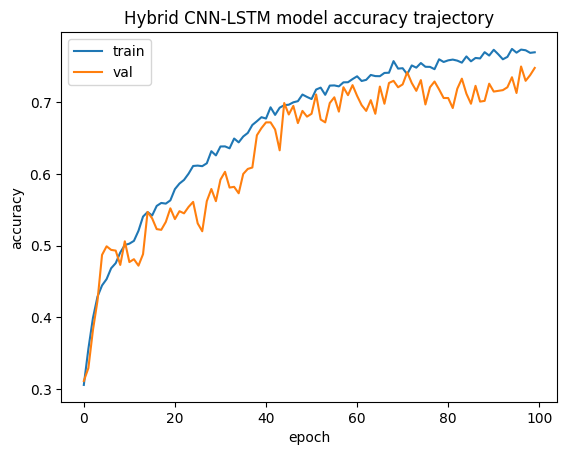

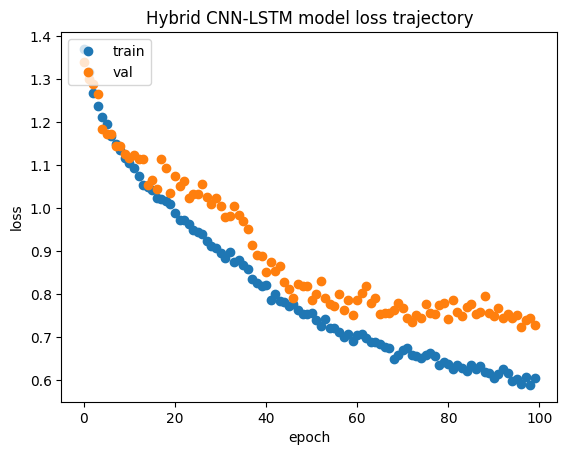

Test accuracy of the hybrid CNN-LSTM model: 0.697516918182373


In [44]:
hybrid_cnn_lstm_model = hybrid()
# ADAM
# Compiling the model
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

plotting(hybrid_cnn_lstm_model_results)


hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])


Epoch 1/100
117/117 [==============================] - 10s 69ms/step - loss: 1.3804 - accuracy: 0.2771 - val_loss: 1.3563 - val_accuracy: 0.2870
Epoch 2/100
117/117 [==============================] - 8s 67ms/step - loss: 1.3390 - accuracy: 0.3428 - val_loss: 1.3150 - val_accuracy: 0.3190
Epoch 3/100
117/117 [==============================] - 8s 68ms/step - loss: 1.2903 - accuracy: 0.3845 - val_loss: 1.2995 - val_accuracy: 0.3340
Epoch 4/100
117/117 [==============================] - 8s 66ms/step - loss: 1.2628 - accuracy: 0.4012 - val_loss: 1.2675 - val_accuracy: 0.3590
Epoch 5/100
117/117 [==============================] - 8s 66ms/step - loss: 1.2379 - accuracy: 0.4314 - val_loss: 1.2575 - val_accuracy: 0.3550
Epoch 6/100
117/117 [==============================] - 8s 68ms/step - loss: 1.2115 - accuracy: 0.4386 - val_loss: 1.2274 - val_accuracy: 0.4070
Epoch 7/100
117/117 [==============================] - 8s 67ms/step - loss: 1.2030 - accuracy: 0.4433 - val_loss: 1.2209 - val_accuracy

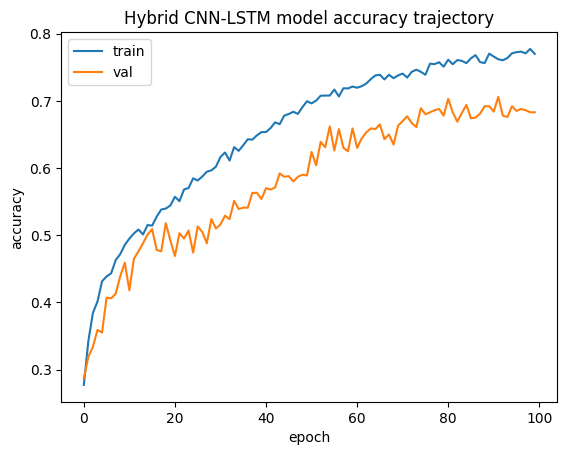

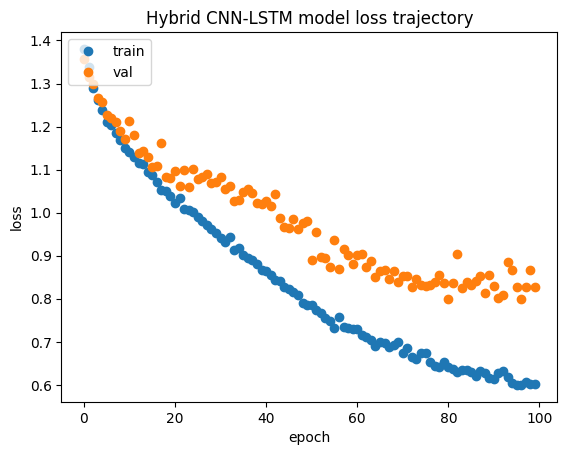

Test accuracy of the hybrid CNN-LSTM model: 0.6817155480384827


In [45]:
hybrid_cnn_lstm_model = hybrid()
# ADAMW
# Compiling the model
hybrid_cnn_lstm_optimizer = keras.optimizers.AdamW(lr=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

plotting(hybrid_cnn_lstm_model_results)

## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Epoch 1/100
117/117 [==============================] - 10s 67ms/step - loss: 1.3883 - accuracy: 0.2761 - val_loss: 1.3692 - val_accuracy: 0.3380
Epoch 2/100
117/117 [==============================] - 8s 65ms/step - loss: 1.3534 - accuracy: 0.3227 - val_loss: 1.3366 - val_accuracy: 0.3600
Epoch 3/100
117/117 [==============================] - 8s 66ms/step - loss: 1.3021 - accuracy: 0.3720 - val_loss: 1.2778 - val_accuracy: 0.3900
Epoch 4/100
117/117 [==============================] - 8s 64ms/step - loss: 1.2543 - accuracy: 0.4129 - val_loss: 1.2215 - val_accuracy: 0.5000
Epoch 5/100
117/117 [==============================] - 8s 64ms/step - loss: 1.2237 - accuracy: 0.4446 - val_loss: 1.1925 - val_accuracy: 0.4270
Epoch 6/100
117/117 [==============================] - 8s 64ms/step - loss: 1.1919 - accuracy: 0.4547 - val_loss: 1.1602 - val_accuracy: 0.4580
Epoch 7/100
117/117 [==============================] - 8s 65ms/step - loss: 1.1625 - accuracy: 0.4768 - val_loss: 1.1632 - val_accuracy

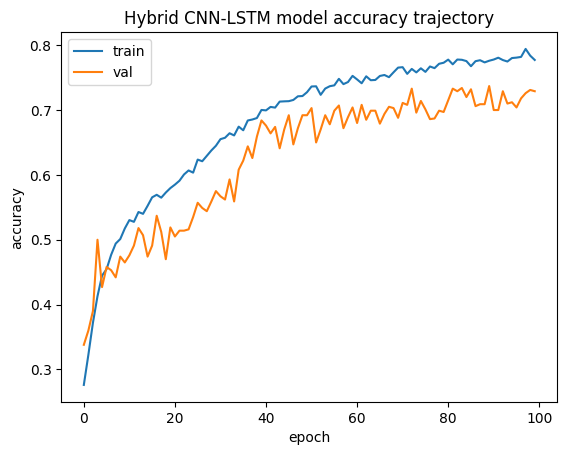

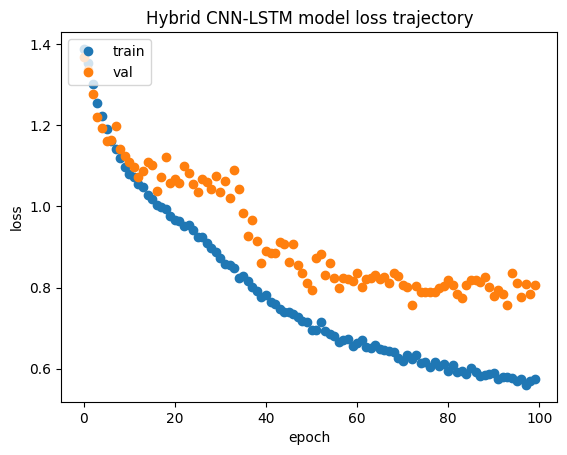

Test accuracy of the hybrid CNN-LSTM model: 0.6501128673553467


In [46]:
hybrid_cnn_lstm_model = hybrid()
# NADAM
# Compiling the model
hybrid_cnn_lstm_optimizer = keras.optimizers.Nadam(lr=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

plotting(hybrid_cnn_lstm_model_results)

## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Epoch 1/100
117/117 [==============================] - 9s 66ms/step - loss: 1.3925 - accuracy: 0.2434 - val_loss: 1.3916 - val_accuracy: 0.2460
Epoch 2/100
117/117 [==============================] - 8s 64ms/step - loss: 1.3883 - accuracy: 0.2567 - val_loss: 1.3930 - val_accuracy: 0.2670
Epoch 3/100
117/117 [==============================] - 8s 65ms/step - loss: 1.3840 - accuracy: 0.2677 - val_loss: 1.3912 - val_accuracy: 0.2620
Epoch 4/100
117/117 [==============================] - 7s 64ms/step - loss: 1.3823 - accuracy: 0.2753 - val_loss: 1.3879 - val_accuracy: 0.2600
Epoch 5/100
117/117 [==============================] - 7s 64ms/step - loss: 1.3808 - accuracy: 0.2847 - val_loss: 1.3857 - val_accuracy: 0.2680
Epoch 6/100
117/117 [==============================] - 7s 64ms/step - loss: 1.3793 - accuracy: 0.2799 - val_loss: 1.3825 - val_accuracy: 0.2680
Epoch 7/100
117/117 [==============================] - 7s 62ms/step - loss: 1.3765 - accuracy: 0.2897 - val_loss: 1.3796 - val_accuracy:

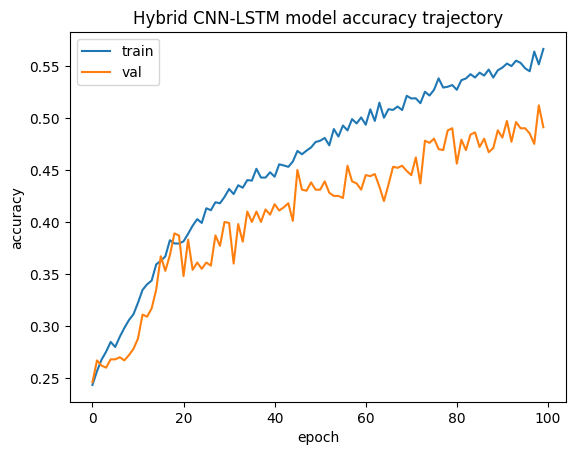

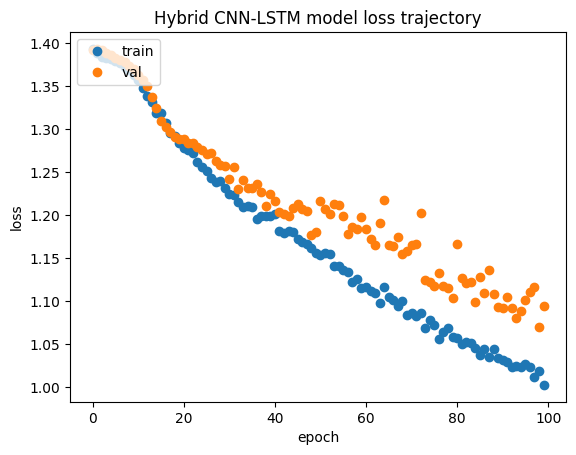

Test accuracy of the hybrid CNN-LSTM model: 0.48758465051651


In [47]:
hybrid_cnn_lstm_model = hybrid()
# SGD
# Compiling the model
hybrid_cnn_lstm_optimizer = keras.optimizers.SGD(lr=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

plotting(hybrid_cnn_lstm_model_results)

## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Epoch 1/100
117/117 [==============================] - 9s 65ms/step - loss: 1.3542 - accuracy: 0.3229 - val_loss: 1.3124 - val_accuracy: 0.3760
Epoch 2/100
117/117 [==============================] - 7s 63ms/step - loss: 1.2989 - accuracy: 0.3626 - val_loss: 1.3281 - val_accuracy: 0.3230
Epoch 3/100
117/117 [==============================] - 7s 64ms/step - loss: 1.2691 - accuracy: 0.3810 - val_loss: 1.2814 - val_accuracy: 0.3470
Epoch 4/100
117/117 [==============================] - 7s 62ms/step - loss: 1.2462 - accuracy: 0.4047 - val_loss: 1.2535 - val_accuracy: 0.3770
Epoch 5/100
117/117 [==============================] - 7s 61ms/step - loss: 1.2193 - accuracy: 0.4212 - val_loss: 1.2390 - val_accuracy: 0.3900
Epoch 6/100
117/117 [==============================] - 7s 62ms/step - loss: 1.2074 - accuracy: 0.4377 - val_loss: 1.1948 - val_accuracy: 0.4560
Epoch 7/100
117/117 [==============================] - 7s 62ms/step - loss: 1.1942 - accuracy: 0.4475 - val_loss: 1.1941 - val_accuracy:

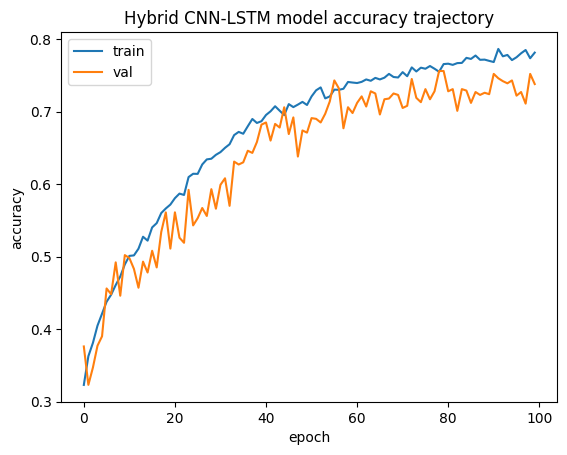

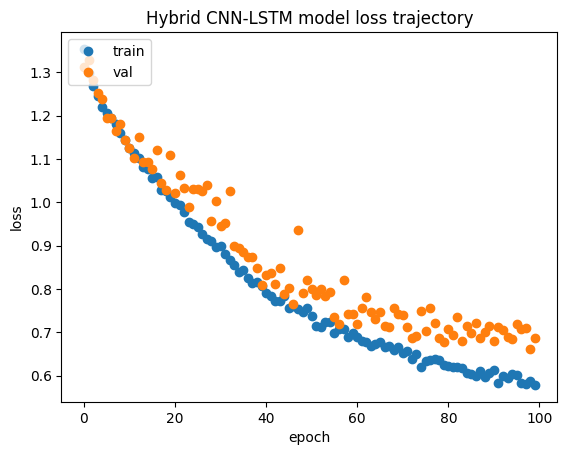

Test accuracy of the hybrid CNN-LSTM model: 0.6817155480384827


In [48]:
hybrid_cnn_lstm_model = hybrid()
# RMSprop
# Compiling the model
hybrid_cnn_lstm_optimizer = keras.optimizers.RMSprop(lr=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

plotting(hybrid_cnn_lstm_model_results)

## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Epoch 1/100
117/117 [==============================] - 9s 66ms/step - loss: 1.3873 - accuracy: 0.2626 - val_loss: 1.3884 - val_accuracy: 0.2560
Epoch 2/100
117/117 [==============================] - 7s 63ms/step - loss: 1.3876 - accuracy: 0.2534 - val_loss: 1.3905 - val_accuracy: 0.2560
Epoch 3/100
117/117 [==============================] - 7s 63ms/step - loss: 1.3850 - accuracy: 0.2649 - val_loss: 1.3909 - val_accuracy: 0.2560
Epoch 4/100
117/117 [==============================] - 7s 64ms/step - loss: 1.3851 - accuracy: 0.2645 - val_loss: 1.3904 - val_accuracy: 0.2560
Epoch 5/100
117/117 [==============================] - 8s 65ms/step - loss: 1.3852 - accuracy: 0.2591 - val_loss: 1.3900 - val_accuracy: 0.2550
Epoch 6/100
117/117 [==============================] - 7s 62ms/step - loss: 1.3864 - accuracy: 0.2560 - val_loss: 1.3891 - val_accuracy: 0.2560
Epoch 7/100
117/117 [==============================] - 7s 62ms/step - loss: 1.3854 - accuracy: 0.2635 - val_loss: 1.3885 - val_accuracy:

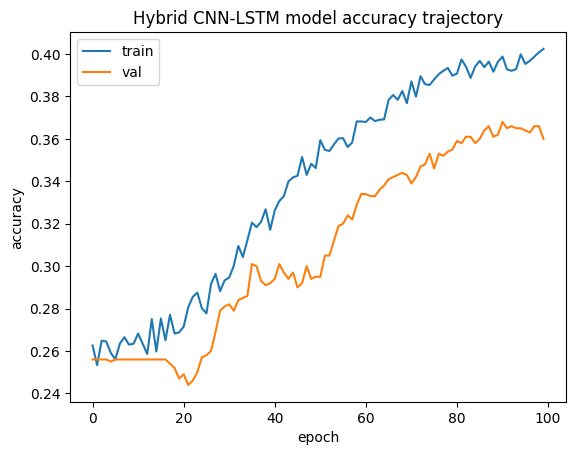

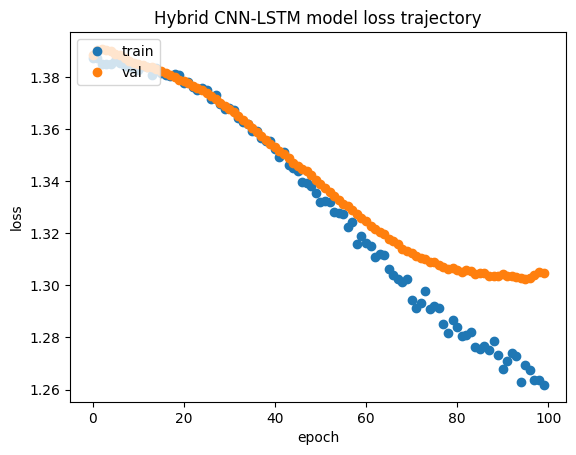

Test accuracy of the hybrid CNN-LSTM model: 0.3656884729862213


In [49]:
hybrid_cnn_lstm_model = hybrid()
# Adagrad
# Compiling the model
hybrid_cnn_lstm_optimizer = keras.optimizers.Adagrad(lr=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

plotting(hybrid_cnn_lstm_model_results)

## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Epoch 1/100
117/117 [==============================] - 9s 66ms/step - loss: 1.3950 - accuracy: 0.2485 - val_loss: 1.3855 - val_accuracy: 0.2910
Epoch 2/100
117/117 [==============================] - 8s 65ms/step - loss: 1.3925 - accuracy: 0.2475 - val_loss: 1.3851 - val_accuracy: 0.2910
Epoch 3/100
117/117 [==============================] - 7s 62ms/step - loss: 1.3924 - accuracy: 0.2472 - val_loss: 1.3849 - val_accuracy: 0.2730
Epoch 4/100
117/117 [==============================] - 7s 62ms/step - loss: 1.3936 - accuracy: 0.2540 - val_loss: 1.3848 - val_accuracy: 0.2660
Epoch 5/100
117/117 [==============================] - 7s 63ms/step - loss: 1.3929 - accuracy: 0.2538 - val_loss: 1.3847 - val_accuracy: 0.2700
Epoch 6/100
117/117 [==============================] - 7s 63ms/step - loss: 1.3942 - accuracy: 0.2426 - val_loss: 1.3847 - val_accuracy: 0.2690
Epoch 7/100
117/117 [==============================] - 7s 63ms/step - loss: 1.3924 - accuracy: 0.2492 - val_loss: 1.3846 - val_accuracy:

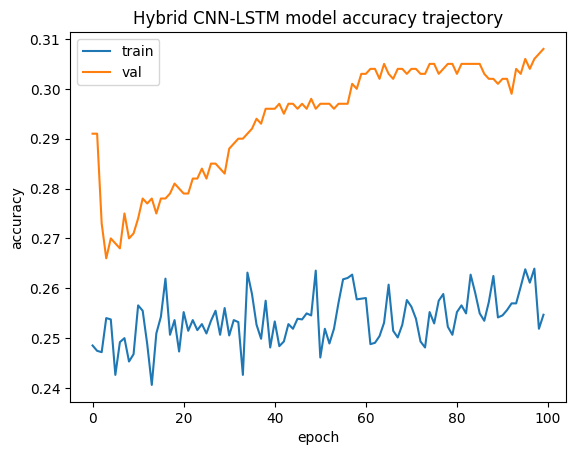

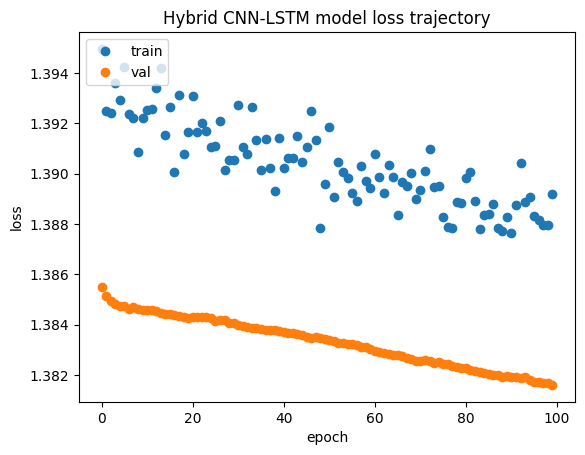

Test accuracy of the hybrid CNN-LSTM model: 0.3340857923030853


In [50]:
hybrid_cnn_lstm_model = hybrid()
# Adadelta
# Compiling the model
hybrid_cnn_lstm_optimizer = keras.optimizers.Adadelta(lr=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

plotting(hybrid_cnn_lstm_model_results)

## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Epoch 1/100
117/117 [==============================] - 9s 65ms/step - loss: 1.3933 - accuracy: 0.2650 - val_loss: 1.3808 - val_accuracy: 0.2800
Epoch 2/100
117/117 [==============================] - 7s 63ms/step - loss: 1.3738 - accuracy: 0.3075 - val_loss: 1.3554 - val_accuracy: 0.2980
Epoch 3/100
117/117 [==============================] - 7s 63ms/step - loss: 1.3570 - accuracy: 0.3328 - val_loss: 1.3162 - val_accuracy: 0.3310
Epoch 4/100
117/117 [==============================] - 7s 63ms/step - loss: 1.3221 - accuracy: 0.3706 - val_loss: 1.2608 - val_accuracy: 0.3860
Epoch 5/100
117/117 [==============================] - 8s 64ms/step - loss: 1.2945 - accuracy: 0.3898 - val_loss: 1.2598 - val_accuracy: 0.3860
Epoch 6/100
117/117 [==============================] - 8s 65ms/step - loss: 1.2708 - accuracy: 0.4048 - val_loss: 1.2271 - val_accuracy: 0.4310
Epoch 7/100
117/117 [==============================] - 8s 66ms/step - loss: 1.2499 - accuracy: 0.4276 - val_loss: 1.2329 - val_accuracy:

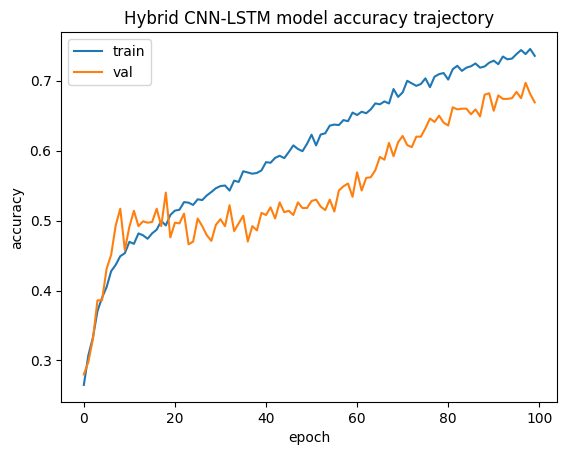

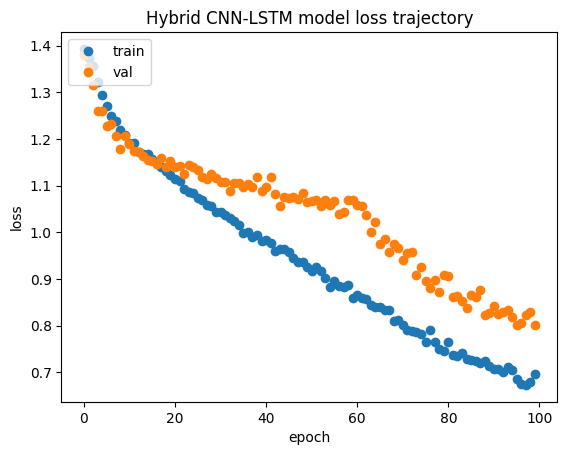

Test accuracy of the hybrid CNN-LSTM model: 0.6839728951454163


In [51]:
hybrid_cnn_lstm_model = hybrid()
# Adamax
# Compiling the model
hybrid_cnn_lstm_optimizer = keras.optimizers.Adamax(lr=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

plotting(hybrid_cnn_lstm_model_results)

## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Epoch 1/100
117/117 [==============================] - 14s 92ms/step - loss: 1.3965 - accuracy: 0.2531 - val_loss: 1.3878 - val_accuracy: 0.2280
Epoch 2/100
117/117 [==============================] - 11s 95ms/step - loss: 1.3927 - accuracy: 0.2576 - val_loss: 1.3875 - val_accuracy: 0.2280
Epoch 3/100
117/117 [==============================] - 11s 91ms/step - loss: 1.3893 - accuracy: 0.2562 - val_loss: 1.3853 - val_accuracy: 0.2280
Epoch 4/100
117/117 [==============================] - 11s 91ms/step - loss: 1.3861 - accuracy: 0.2647 - val_loss: 1.3850 - val_accuracy: 0.2270
Epoch 5/100
117/117 [==============================] - 11s 91ms/step - loss: 1.3843 - accuracy: 0.2716 - val_loss: 1.3841 - val_accuracy: 0.2270
Epoch 6/100
117/117 [==============================] - 11s 97ms/step - loss: 1.3848 - accuracy: 0.2765 - val_loss: 1.3839 - val_accuracy: 0.2270
Epoch 7/100
117/117 [==============================] - 11s 98ms/step - loss: 1.3810 - accuracy: 0.2786 - val_loss: 1.3821 - val_ac

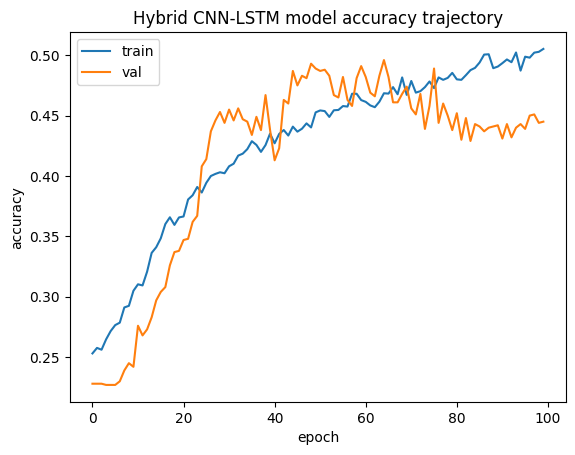

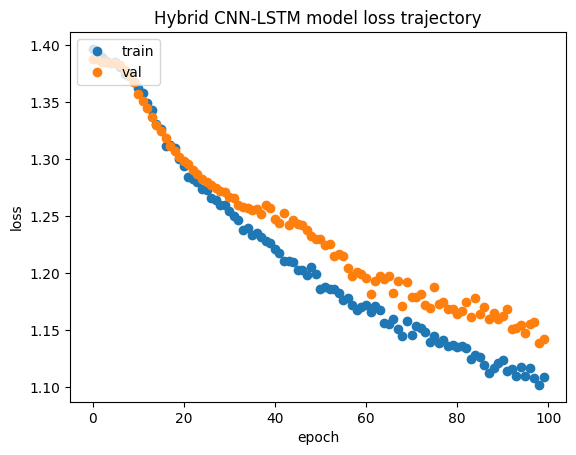

Test accuracy of the hybrid CNN-LSTM model: 0.45146727561950684


In [52]:
hybrid_cnn_lstm_model = hybrid()
# Adafactor
# Compiling the model
hybrid_cnn_lstm_optimizer = keras.optimizers.Adafactor(lr=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

plotting(hybrid_cnn_lstm_model_results)

## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])